In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=10,  
                             zoom_range = 0.1,  
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             brightness_range=(0.9, 1.1),
                             rescale=1/255.0)

valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [8]:
im_size = 300
batch_size = 128

train_generator = train_datagen.flow_from_directory(
    directory=r"/kaggle/input/vietnamese-foods/Images/Train",
    target_size=(im_size, im_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 17581 images belonging to 30 classes.


In [9]:
valid_generator = valid_datagen.flow_from_directory(
    directory=r"/kaggle/input/vietnamese-foods/Images/Validate",
    target_size=(im_size, im_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 2515 images belonging to 30 classes.


In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [11]:
for image in train_generator:
  print(type(image))
  print(type(image[0]))
  print(image[0].shape)
  break

<class 'tuple'>
<class 'numpy.ndarray'>
(128, 300, 300, 3)


In [12]:
image[0].shape

(128, 300, 300, 3)

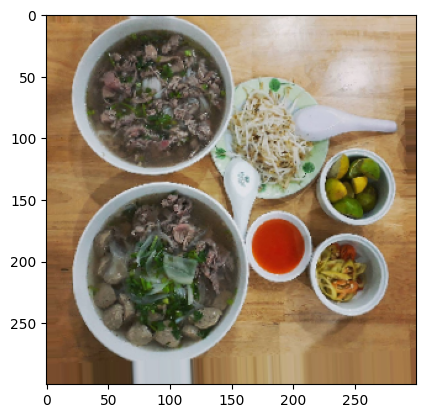

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image[0][0])

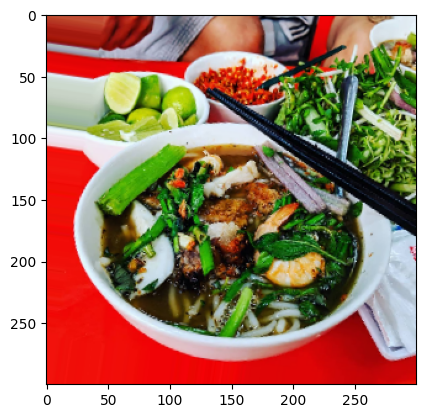

In [14]:
plt.imshow(image[0][5])

In [15]:
CLASSES = 30
INITIAL_EPOCHS = 15
FINE_TUNE_EPOCHS = 15
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
FINE_TUNE_AT = 516

In [16]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

pretrained_model = ResNet152V2(weights='imagenet', include_top=False)
last_output = pretrained_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
base_checkpointer = ModelCheckpoint(
    filepath = '/kaggle/working/base_model_best.h5', 
    save_best_only = True, 
    verbose = 1
)

fine_tune_checkpointer = ModelCheckpoint(
    filepath = '/kaggle/working/fine_tune_model_best.h5', 
    save_best_only = True,
    verbose = 1, 
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    verbose=1,
    mode='min',
    min_lr=1e-6,
)

# Stop if no improvement after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [18]:
for layer in pretrained_model.layers: layer.trainable = False
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    steps_per_epoch = train_generator.n // batch_size,
    callbacks = [base_checkpointer, reduce_lr],
    epochs = 30,
    verbose = 1,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1765542690.191362     113 service.cc:148] XLA service 0x7e94d0003f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765542690.192267     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765542690.192292     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765542693.952439     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765542725.698705     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3810 - loss: 2.2359
Epoch 1: val_loss improved from inf to 1.24041, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - accuracy: 0.3818 - loss: 2.2325 - val_accuracy: 0.6291 - val_loss: 1.2404 - learning_rate: 0.0010
Epoch 2/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.6797 - loss: 1.1333

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.24041
137/137 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.6797 - loss: 1.1333 - val_accuracy: 0.6176 - val_loss: 1.2529 - learning_rate: 0.0010
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6317 - loss: 1.2059
Epoch 3: val_loss improved from 1.24041 to 1.19532, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - accuracy: 0.6317 - loss: 1.2057 - val_accuracy: 0.6390 - val_loss: 1.1953 - learning_rate: 0.0010
Epoch 4/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.5703 - loss: 1.3137
Epoch 4: val_loss improved from 1.19532 to 1.08381, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 272ms/step - accuracy: 0.5703 - loss: 1.3137 - val_accuracy: 0.6719 - val_loss: 1.0838 - learning_rate: 0.0010
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6853 - loss: 1.0213
Epoch 5: val_loss improved from 1.08381 to 1.02581, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 567s 4s/step - accuracy: 0.6853 - loss: 1.0213 - val_accuracy: 0.6924 - val_loss: 1.0258 - learning_rate: 0.0010
Epoch 6/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.7031 - loss: 1.0412
Epoch 6: val_loss did not improve from 1.02581
137/137 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - accuracy: 0.7031 - loss: 1.0412 - val_accuracy: 0.6846 - val_loss: 1.0556 - learning_rate: 0.0010
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7225 - loss: 0.8894
Epoch 7: val_loss improved from 1.02581 to 0.98576, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.7224 - loss: 0.8895 - val_accuracy: 0.7089 - val_loss: 0.9858 - learning_rate: 0.0010
Epoch 8/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.6875 - loss: 0.9597
Epoch 8: val_loss improved from 0.98576 to 0.96792, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - accuracy: 0.6875 - loss: 0.9597 - val_accuracy: 0.7122 - val_loss: 0.9679 - learning_rate: 0.0010
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7407 - loss: 0.8283
Epoch 9: val_loss did not improve from 0.96792
137/137 ━━━━━━━━━━━━━━━━━━━━ 572s 4s/step - accuracy: 0.7407 - loss: 0.8283 - val_accuracy: 0.6908 - val_loss: 1.0251 - learning_rate: 0.0010
Epoch 10/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.6953 - loss: 1.0231
Epoch 10: val_loss did not improve from 0.96792
137/137 ━━━━━━━━━━━━━━━━━━━━ 34s 237ms/step - accuracy: 0.6953 - loss: 1.0231 - val_accuracy: 0.7023 - val_loss: 0.9958 - learning_rate: 0.0010
Epoch 11/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7661 - loss: 0.7407
Epoch 11: val_loss did not improve from 0.96792
137/137 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.7661 - loss: 0.7408 - val_accuracy: 0.7130 - val_loss: 0.9756 - learning_rate: 0.0010
Epoch 12/30
  1/137 ━━━━━━

137/137 ━━━━━━━━━━━━━━━━━━━━ 584s 4s/step - accuracy: 0.7755 - loss: 0.6975 - val_accuracy: 0.7225 - val_loss: 0.9538 - learning_rate: 0.0010
Epoch 14/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.7656 - loss: 0.7221
Epoch 14: val_loss improved from 0.95376 to 0.95138, saving model to /kaggle/working/base_model_best.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 35s 248ms/step - accuracy: 0.7656 - loss: 0.7221 - val_accuracy: 0.7085 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 15/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7903 - loss: 0.6543
Epoch 15: val_loss did not improve from 0.95138
137/137 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - accuracy: 0.7903 - loss: 0.6544 - val_accuracy: 0.7085 - val_loss: 0.9931 - learning_rate: 0.0010
Epoch 16/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:26 2s/step - accuracy: 0.8203 - loss: 0.6287
Epoch 16: val_loss did not improve from 0.95138
137/137 ━━━━━━━━━━━━━━━━━━━━ 33s 235ms/step - accuracy: 0.8203 - loss: 0.6287 - val_accuracy: 0.7105 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 17/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8056 - loss: 0.6043
Epoch 17: val_loss did not improve from 0.95138
137/137 ━━━━━━━━━━━━━━━━━━━━ 570s 4s/step - accuracy: 0.8056 - loss: 0.6045 - val_accuracy: 0.7303 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 18/30
  1/137 ━━━━

137/137 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.8211 - loss: 0.5570 - val_accuracy: 0.7286 - val_loss: 0.9377 - learning_rate: 0.0010
Epoch 20/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.8594 - loss: 0.4673
Epoch 20: val_loss did not improve from 0.93767
137/137 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.8594 - loss: 0.4673 - val_accuracy: 0.7118 - val_loss: 0.9841 - learning_rate: 0.0010
Epoch 21/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8260 - loss: 0.5498
Epoch 21: val_loss did not improve from 0.93767
137/137 ━━━━━━━━━━━━━━━━━━━━ 583s 4s/step - accuracy: 0.8260 - loss: 0.5499 - val_accuracy: 0.7257 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 22/30
  1/137 ━━━━━━━━━━━━━━━━━━━━ 3:24 2s/step - accuracy: 0.7812 - loss: 0.6572
Epoch 22: val_loss did not improve from 0.93767
137/137 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.7812 - loss: 0.6572 - val_accuracy: 0.7270 - val_loss: 0.9639 - learning_rate: 0.0010
Epoch 23/30
137/137 ━━

In [20]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

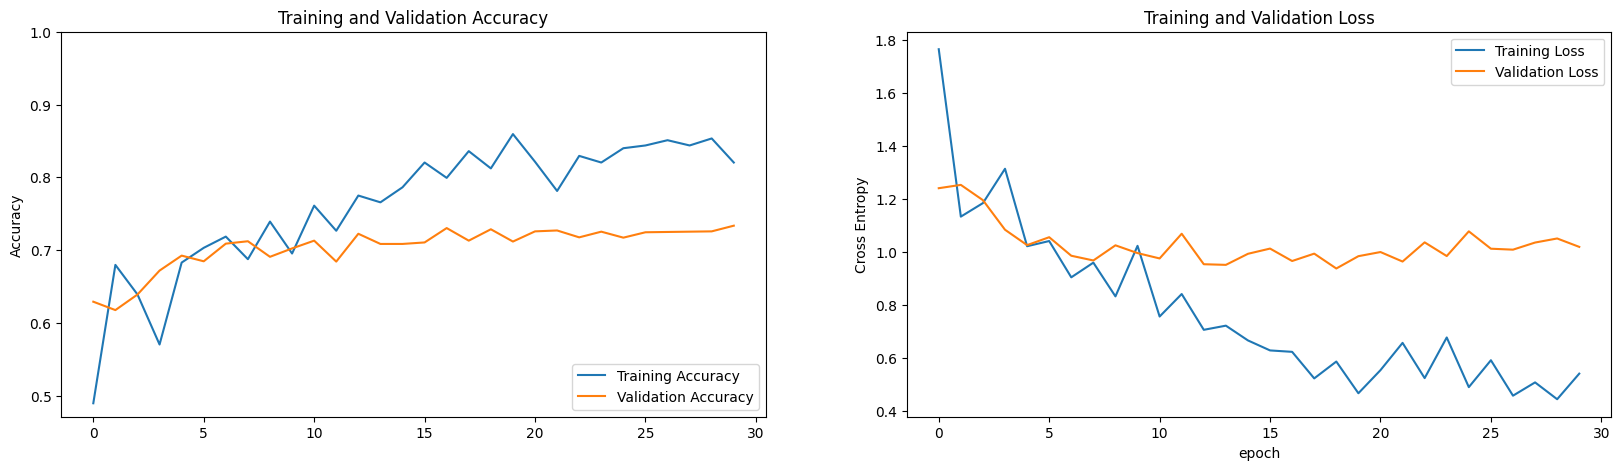

In [21]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
# plt.savefig(BASE_MODEL_FIG)
plt.show()

In [22]:
model.save('Resnet152.h5')